In [1]:
import torch
import wave
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import numpy as np


In [2]:
text = "Mesdames et messieurs, bonjour. Nous sommes ravis de vous accueillir à bord de ce vol Air France. Nous vous remercions de votre confiance et vous souhaitons un agréable voyage."

In [3]:
def get_audio_duration(filepath_no_extention):
    try :
        with wave.open(filepath_no_extention + '.wav', 'r') as f:
            frames = f.getnframes()
            rate = f.getframerate()
    except:
        with wave.open(filepath_no_extention + '.mp3', 'r') as f:
            frames = f.getnframes()
            rate = f.getframerate()
    
    return frames / float(rate)

def save_to_csv(output_name, time_init, time_infer):
    df = pd.read_csv('time_analysis.csv', header=0)
    df = df.append({
        'file': output_name, 
        'time_init': time_init, 
        'time_infer': time_infer, 
        'model': output_name.split('_')[0],
        'audio_duration': get_audio_duration(output_name),
        'text': text
        }, ignore_index=True)
    df.to_csv('time_analysis.csv', index=False)

## PyTTSX4

In [4]:
import pyttsx4

In [5]:
t1 = time.time()
engine = pyttsx4.init()
t2 = time.time()
time_init = t2 - t1

t1 = time.time()
engine.save_to_file(text, 'pyttsx4.mp3')
engine.runAndWait()
t2 = time.time()
time_infer = t2 - t1

save_to_csv('pyttsx4', time_init, time_infer)

C:\Users\echriston\AppData\Local\Temp\ipykernel_13152\2414183338.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


## MELO

In [6]:
import MeCab
from melo.api import TTS

c:\Users\echriston\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Speed is adjustable
speed = 1.0

# CPU is sufficient for real-time inference.
# You can set it manually to 'cpu' or 'cuda' or 'cuda:0' or 'mps'
device = 'auto' # Will automatically use GPU if available

t1 = time.time()
model = TTS(language='FR', device=device)
speaker_ids = model.hps.data.spk2id
t2 = time.time()
time_init = t2 - t1

# American accent
output_path = 'melo-fr.wav'
t1 = time.time()
model.tts_to_file(text, speaker_ids['FR'], output_path, speed=speed)
t2 = time.time()
time_infer = t2 - t1

save_to_csv('melo-fr', time_init, time_infer)

c:\Users\echriston\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


 > Text split to sentences.
Mesdames et messieurs, bonjour. Nous sommes ravis de vous accueillir à bord de ce vol Air France. Nous vous remercions de votre confiance et vous souhaitons un agréable voyage.
 > ===========================


100%|██████████| 1/1 [00:08<00:00,  8.38s/it]
C:\Users\echriston\AppData\Local\Temp\ipykernel_13152\2414183338.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


## TTS lib

In [8]:
from TTS.api import TTS

In [9]:
# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"

# List available 🐸TTS models
print("\n".join(TTS().list_models().list_models()))

tts_models/multilingual/multi-dataset/xtts_v2
tts_models/multilingual/multi-dataset/xtts_v1.1
tts_models/multilingual/multi-dataset/your_tts
tts_models/multilingual/multi-dataset/bark
tts_models/bg/cv/vits
tts_models/cs/cv/vits
tts_models/da/cv/vits
tts_models/et/cv/vits
tts_models/ga/cv/vits
tts_models/en/ek1/tacotron2
tts_models/en/ljspeech/tacotron2-DDC
tts_models/en/ljspeech/tacotron2-DDC_ph
tts_models/en/ljspeech/glow-tts
tts_models/en/ljspeech/speedy-speech
tts_models/en/ljspeech/tacotron2-DCA
tts_models/en/ljspeech/vits
tts_models/en/ljspeech/vits--neon
tts_models/en/ljspeech/fast_pitch
tts_models/en/ljspeech/overflow
tts_models/en/ljspeech/neural_hmm
tts_models/en/vctk/vits
tts_models/en/vctk/fast_pitch
tts_models/en/sam/tacotron-DDC
tts_models/en/blizzard2013/capacitron-t2-c50
tts_models/en/blizzard2013/capacitron-t2-c150_v2
tts_models/en/multi-dataset/tortoise-v2
tts_models/en/jenny/jenny
tts_models/es/mai/tacotron2-DDC
tts_models/es/css10/vits
tts_models/fr/mai/tacotron2-DDC

In [10]:
def test_model(model_name, text, speaker_path, save_csv=True, display=True):
    start = time.time()
    # Load model
    tts = TTS(model_name).to(device)
    time_init = time.time() - start

    output_name = get_output_name(model_name, speaker_path)

    # Synthesize
    if "multilingual" in model_name:
        try:
            start = time.time()
            tts.tts_to_file(text=text, speaker_wav=speaker_path, file_path=output_name + '.wav', language="fr-fr")
            time_infer = time.time() - start
        except:
            try:
                start = time.time()
                tts.tts_to_file(text=text, speaker_wav=speaker_path, file_path=output_name + '.wav', language="fr")
                time_infer = time.time() - start
            except:
                try:
                    start = time.time()
                    tts.tts_to_file(text=text, speaker_wav=speaker_path, file_path=output_name + '.wav', language="fra")
                    time_infer = time.time() - start
                except Exception as e:
                    raise e
    else:
        start = time.time()
        tts.tts_to_file(text=text, speaker_wav=speaker_path, file_path=output_name + '.wav')
        time_infer = time.time() - start
    
    if display:
        print(f"\n==============================================\nModel: {model_name}")
        print(f"Time to initialize the model: {time_init:.2f} s")
        print(f"Time to synthesize the text: {time_infer:.2f} s")

    if save_csv:
        save_to_csv(output_name, time_init, time_infer)

def get_output_name(model_name, speaker_path):
    if len(model_name.split('/')) != 4:
        raise ValueError('model_name must be in the form of "tts_model/language/model_tag/model_name"')
    _, language, model_tag, model_main = model_name.split('/')
    return model_main + '-' + model_tag + '-' + language + '-' + speaker_path.split('/')[-1].split('.')[0]

In [11]:
tts_to_test = [
    "tts_models/multilingual/multi-dataset/xtts_v2",
    "tts_models/multilingual/multi-dataset/your_tts",
    "tts_models/fr/mai/tacotron2-DDC",
    "tts_models/fr/css10/vits",
    "tts_models/fra/fairseq/vits",
    "tts_models/acf/fairseq/vits",
]

voice_folder = "../../../data/stored/assistant/voices/"

speakers_to_test = [voice_folder + speaker for speaker in os.listdir(voice_folder) if speaker.endswith('.wav') or speaker.endswith('.flac') or speaker.endswith('.mp3')]
print(speakers_to_test)

for model in tts_to_test:
    if "multilingual" in model:
        speakers = speakers_to_test
    else:
        speakers = [speakers_to_test[0]]
    for speaker in speakers:
        print(f"Testing {model} with speaker {speaker}")
        test_model(model, text, speaker, save_csv=True, display=True)
        print("==============================================")


['../../../data/stored/assistant/voices/eliot_christon.mp3', '../../../data/stored/assistant/voices/eugenie_declaron.mp3', '../../../data/stored/assistant/voices/example_reference.mp3', '../../../data/stored/assistant/voices/jean_pierre_pernaut.mp3', '../../../data/stored/assistant/voices/perrine_laffont.mp3', '../../../data/stored/assistant/voices/pierre_faury.mp3', '../../../data/stored/assistant/voices/ptisham.mp3', '../../../data/stored/assistant/voices/roberto_caurand.mp3', '../../../data/stored/assistant/voices/teddy_riner.mp3', '../../../data/stored/assistant/voices/thomas_oxisoglou.mp3']
Testing tts_models/multilingual/multi-dataset/xtts_v2 with speaker ../../../data/stored/assistant/voices/eliot_christon.mp3
 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.
 > Using model: xtts
 > Text splitted to sentences.
['Mesdames et messieurs, bonjour.', 'Nous sommes ravis de vous accueillir à bord de ce vol Air France.', 'Nous vous remercions de votre confiance et 

C:\Users\echriston\AppData\Local\Temp\ipykernel_13152\2414183338.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Using model: xtts
 > Text splitted to sentences.
['Mesdames et messieurs, bonjour.', 'Nous sommes ravis de vous accueillir à bord de ce vol Air France.', 'Nous vous remercions de votre confiance et vous souhaitons un agréable voyage.']
 > Text splitted to sentences.
['Mesdames et messieurs, bonjour.', 'Nous sommes ravis de vous accueillir à bord de ce vol Air France.', 'Nous vous remercions de votre confiance et vous souhaitons un agréable voyage.']
 > Processing time: 37.74898958206177
 > Real-time factor: 2.8466662800426197

Model: tts_models/multilingual/multi-dataset/xtts_v2
Time to initialize the model: 12.86 s
Time to synthesize the text: 37.80 s
Testing tts_models/multilingual/multi-dataset/xtts_v2 with speaker ../../../data/stored/assistant/voices/example_reference.mp3
 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.


C:\Users\echriston\AppData\Local\Temp\ipykernel_13152\2414183338.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Using model: xtts
 > Text splitted to sentences.
['Mesdames et messieurs, bonjour.', 'Nous sommes ravis de vous accueillir à bord de ce vol Air France.', 'Nous vous remercions de votre confiance et vous souhaitons un agréable voyage.']
 > Text splitted to sentences.
['Mesdames et messieurs, bonjour.', 'Nous sommes ravis de vous accueillir à bord de ce vol Air France.', 'Nous vous remercions de votre confiance et vous souhaitons un agréable voyage.']
 > Processing time: 46.87422323226929
 > Real-time factor: 2.523084751473308

Model: tts_models/multilingual/multi-dataset/xtts_v2
Time to initialize the model: 13.65 s
Time to synthesize the text: 46.94 s
Testing tts_models/multilingual/multi-dataset/xtts_v2 with speaker ../../../data/stored/assistant/voices/jean_pierre_pernaut.mp3
 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.


C:\Users\echriston\AppData\Local\Temp\ipykernel_13152\2414183338.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Using model: xtts
 > Text splitted to sentences.
['Mesdames et messieurs, bonjour.', 'Nous sommes ravis de vous accueillir à bord de ce vol Air France.', 'Nous vous remercions de votre confiance et vous souhaitons un agréable voyage.']
 > Text splitted to sentences.
['Mesdames et messieurs, bonjour.', 'Nous sommes ravis de vous accueillir à bord de ce vol Air France.', 'Nous vous remercions de votre confiance et vous souhaitons un agréable voyage.']
 > Processing time: 28.367160320281982
 > Real-time factor: 3.008348812342332

Model: tts_models/multilingual/multi-dataset/xtts_v2
Time to initialize the model: 13.22 s
Time to synthesize the text: 28.40 s
Testing tts_models/multilingual/multi-dataset/xtts_v2 with speaker ../../../data/stored/assistant/voices/perrine_laffont.mp3
 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.


C:\Users\echriston\AppData\Local\Temp\ipykernel_13152\2414183338.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Using model: xtts
 > Text splitted to sentences.
['Mesdames et messieurs, bonjour.', 'Nous sommes ravis de vous accueillir à bord de ce vol Air France.', 'Nous vous remercions de votre confiance et vous souhaitons un agréable voyage.']
 > Text splitted to sentences.
['Mesdames et messieurs, bonjour.', 'Nous sommes ravis de vous accueillir à bord de ce vol Air France.', 'Nous vous remercions de votre confiance et vous souhaitons un agréable voyage.']
 > Processing time: 37.8365843296051
 > Real-time factor: 2.8938089116619694

Model: tts_models/multilingual/multi-dataset/xtts_v2
Time to initialize the model: 13.26 s
Time to synthesize the text: 37.88 s
Testing tts_models/multilingual/multi-dataset/xtts_v2 with speaker ../../../data/stored/assistant/voices/pierre_faury.mp3
 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.


C:\Users\echriston\AppData\Local\Temp\ipykernel_13152\2414183338.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Using model: xtts
 > Text splitted to sentences.
['Mesdames et messieurs, bonjour.', 'Nous sommes ravis de vous accueillir à bord de ce vol Air France.', 'Nous vous remercions de votre confiance et vous souhaitons un agréable voyage.']
 > Text splitted to sentences.
['Mesdames et messieurs, bonjour.', 'Nous sommes ravis de vous accueillir à bord de ce vol Air France.', 'Nous vous remercions de votre confiance et vous souhaitons un agréable voyage.']
 > Processing time: 47.32716965675354
 > Real-time factor: 2.807090840680589

Model: tts_models/multilingual/multi-dataset/xtts_v2
Time to initialize the model: 13.20 s
Time to synthesize the text: 47.39 s
Testing tts_models/multilingual/multi-dataset/xtts_v2 with speaker ../../../data/stored/assistant/voices/ptisham.mp3
 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.


C:\Users\echriston\AppData\Local\Temp\ipykernel_13152\2414183338.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Using model: xtts
 > Text splitted to sentences.
['Mesdames et messieurs, bonjour.', 'Nous sommes ravis de vous accueillir à bord de ce vol Air France.', 'Nous vous remercions de votre confiance et vous souhaitons un agréable voyage.']
 > Text splitted to sentences.
['Mesdames et messieurs, bonjour.', 'Nous sommes ravis de vous accueillir à bord de ce vol Air France.', 'Nous vous remercions de votre confiance et vous souhaitons un agréable voyage.']
 > Processing time: 40.63106846809387
 > Real-time factor: 2.9379658551126435

Model: tts_models/multilingual/multi-dataset/xtts_v2
Time to initialize the model: 13.15 s
Time to synthesize the text: 40.68 s
Testing tts_models/multilingual/multi-dataset/xtts_v2 with speaker ../../../data/stored/assistant/voices/roberto_caurand.mp3
 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.


C:\Users\echriston\AppData\Local\Temp\ipykernel_13152\2414183338.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


 > Using model: xtts
 > Text splitted to sentences.
['Mesdames et messieurs, bonjour.', 'Nous sommes ravis de vous accueillir à bord de ce vol Air France.', 'Nous vous remercions de votre confiance et vous souhaitons un agréable voyage.']
 > Text splitted to sentences.
['Mesdames et messieurs, bonjour.', 'Nous sommes ravis de vous accueillir à bord de ce vol Air France.', 'Nous vous remercions de votre confiance et vous souhaitons un agréable voyage.']


## Latency Analysis

In [ ]:
# load time_analysis.csv
df = pd.read_csv('time_analysis.csv', header=0)

df = df.sort_values(by=['model', 'audio_duration'])

# display the dataframe
print(df.head())

                                   file  time_init  time_infer  \
27                              melo-fr   1.596250    6.594031   
1                               melo-fr   1.936652   14.842950   
26                              pyttsx4   0.447547    0.165776   
0                               pyttsx4   0.196557    0.148779   
48  tacotron2-DDC-mai-fr-eliot_christon   2.255196    0.996812   

                         model  audio_duration  \
27                     melo-fr        1.942426   
1                      melo-fr       17.329206   
26                     pyttsx4        2.564989   
0                      pyttsx4       17.307800   
48  tacotron2-DDC-mai-fr-eliot        1.899333   

                                                 text  
27                     Hey, moi c'est NAO, ça roule ?  
1   Connaissez-vous Wemby? Face aux New-Yorkais, i...  
26                     Hey, moi c'est NAO, ça roule ?  
0   Connaissez-vous Wemby? Face aux New-Yorkais, i...  
48                    

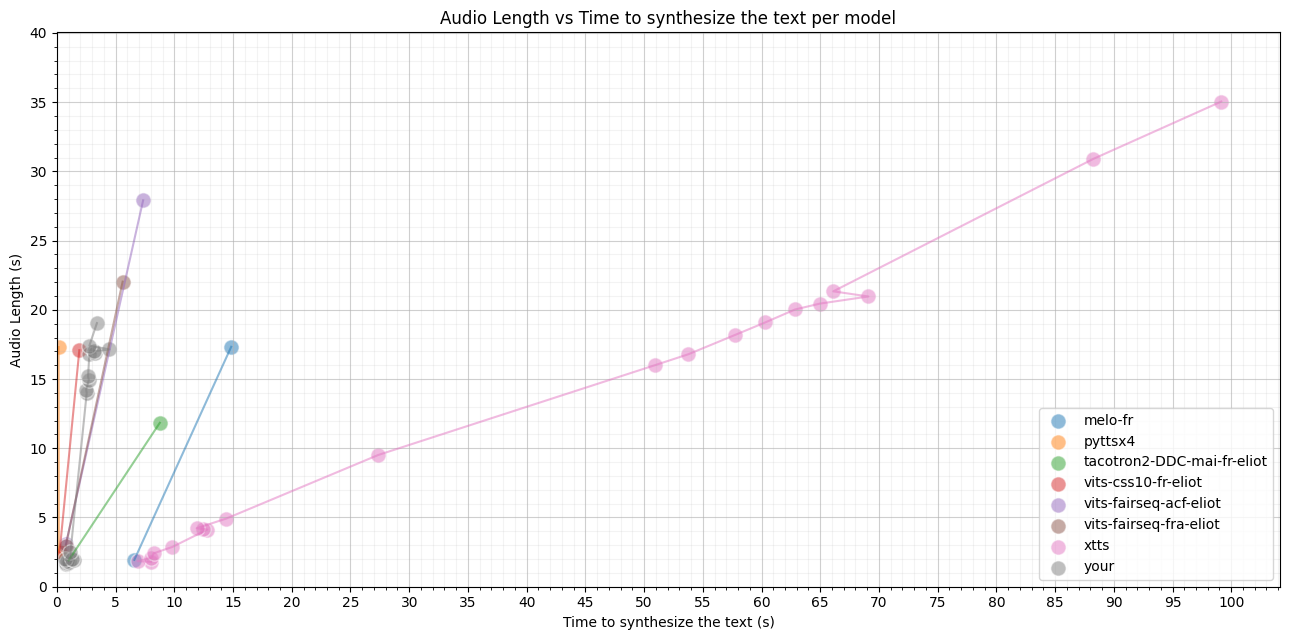

In [ ]:
# plot the audio length vs the time to synthesize the text per model

fig, ax = plt.subplots(figsize=(13, 6.5))
for i, txt in enumerate(df['model'].unique()):
    if txt == 'xtts':
        continue
    df_filtered = df[df['model'] == txt]
    ax.scatter(df_filtered['time_infer'], df_filtered['audio_duration'], label=txt, s=120, alpha=0.5, edgecolors="w", linewidth=1, marker='o')
    ax.plot(df_filtered['time_infer'], df_filtered['audio_duration'], alpha=0.5)
ax.legend()
ax.set_ylabel('Audio Length (s)')
ax.set_xlabel('Time to synthesize the text (s)')
ax.set_title('Audio Length vs Time to synthesize the text per model')
major_ticks = np.arange(0, 151, 5)
minor_ticks = np.arange(0, 151, 1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='major', alpha=0.6)
ax.grid(which='minor', alpha=0.15)
ax.set_xlim(max(0, min(df['time_infer']) - 5), max(df['time_infer']) + 5)
ax.set_ylim(max(0, min(df['audio_duration']) - 5), max(df['audio_duration']) + 5)
plt.tight_layout()
plt.show()
